# Requirements

In [8]:
#%pip install ema_workbench
#%pip install ipyparallel

# Simplest model
The simplest case is where we have a model available through a python function. 

In [1]:
def some_model(x1=None, x2=None, x3=None):
    return {'y':x1*x2+x3}

In order to control this model from the workbench, We can instantiate a orkbench Model by passing it a name, and the function.

In [9]:
from ema_workbench import Model
model = Model('simpleModel', function=some_model) #instantiate the model

## Inputs and outputs
Next, we need to specify the uncertainties and the outcomes of the model. In this case, the uncertainties are x1, x2, and x3, while the outcome is y. Here, we specify that x1 is some value between 0.1, and 10, while both x2 and x3 are somewhere between -0.01 and 0.01.

In [11]:
from ema_workbench import RealParameter, ScalarOutcome
#specify uncertainties
model.uncertainties = [RealParameter("x1", 0.1, 10),
                       RealParameter("x2", -0.01,0.01),
                       RealParameter("x3", -0.01,0.01)]
#specify outcomes
model.outcomes = [ScalarOutcome('y')]

## Run experiments
Having implemented this model, we can now investigate the model behavior over the set of uncertainties by simply calling the function perform_experiments(), It takes the model we just specified and will execute 100 experiments. 

By default, these experiments are generated using a Latin Hypercube sampling, but Monte Carlo sampling and Full factorial sampling are also readily available.

In [12]:
from ema_workbench import  perform_experiments
results = perform_experiments(model, 100)

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 3931.37it/s]


In [31]:
print(results[0].iloc[0])
print(results[1]['y'][0])

x1             1.472408
x2             0.009767
x3             0.006534
scenario              0
policy             None
model       simpleModel
Name: 0, dtype: object
0.020916130954406295


# Lake problem

In [1]:
import numpy as np
import math
from scipy.optimize import brentq


def lake_problem(
    b=0.42,  # decay rate for P in lake (0.42 = irreversible)
    q=2.0,  # recycling exponent
    mean=0.02,  # mean of natural inflows
    stdev=0.001,  # future utility discount rate
    delta=0.98,  # standard deviation of natural inflows
    alpha=0.4,  # utility from pollution
    nsamples=100,  # Monte Carlo sampling of natural inflows
    **kwargs,
):
    try:
        decisions = [kwargs[str(i)] for i in range(100)]
    except KeyError:
        decisions = [0] * 100
        print("No valid decisions found, using 0 water release every year as default")

    nvars = len(decisions)
    decisions = np.array(decisions)

    # Calculate the critical pollution level (Pcrit)
    Pcrit = brentq(lambda x: x**q / (1 + x**q) - b * x, 0.01, 1.5)

    # Generate natural inflows using lognormal distribution
    natural_inflows = np.random.lognormal(
        mean=math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
        sigma=math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
        size=(nsamples, nvars),
    )

    # Initialize the pollution level matrix X
    X = np.zeros((nsamples, nvars))

    # Loop through time to compute the pollution levels
    for t in range(1, nvars):
        X[:, t] = (
            (1 - b) * X[:, t - 1]
            + (X[:, t - 1] ** q / (1 + X[:, t - 1] ** q))
            + decisions[t - 1]
            + natural_inflows[:, t - 1]
        )

    # Calculate the average daily pollution for each time step
    average_daily_P = np.mean(X, axis=0)

    # Calculate the reliability (probability of the pollution level being below Pcrit)
    reliability = np.sum(X < Pcrit) / float(nsamples * nvars)

    # Calculate the maximum pollution level (max_P)
    max_P = np.max(average_daily_P)

    # Calculate the utility by discounting the decisions using the discount factor (delta)
    utility = np.sum(alpha * decisions * np.power(delta, np.arange(nvars)))

    # Calculate the inertia (the fraction of time steps with changes larger than 0.02)
    inertia = np.sum(np.abs(np.diff(decisions)) > 0.02) / float(nvars - 1)

    return max_P, utility, inertia, reliability

## Creating the EMA workbench mdoel

In [2]:
from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)
lake_model.time_horizon = 100

# specify uncertainties
lake_model.uncertainties = [
RealParameter("b", 0.1, 0.45),
RealParameter("q", 2.0, 4.5),
RealParameter("mean", 0.01, 0.05),
RealParameter("stdev", 0.001, 0.005),
RealParameter("delta", 0.93, 0.99),
]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in range(lake_model.time_horizon)]

    # specify outcomes
lake_model.outcomes = [
    ScalarOutcome("max_P"),
    ScalarOutcome("utility"),
    ScalarOutcome("inertia"),
    ScalarOutcome("reliability"),
]

# override some of the defaults of the model
lake_model.constants = [Constant("alpha", 0.41), Constant("nsamples", 150)]

## Run the experiments

In [4]:
from ema_workbench.em_framework.evaluators import Samplers
# generate some random policies by sampling over levers
n_scenarios = 100# 1000
n_policies = 2 #4

with MultiprocessingEvaluator(lake_model) as evaluator:
    res = evaluator.perform_experiments(n_scenarios, n_policies, lever_sampling=Samplers.MC)

In [4]:
from ema_workbench import perform_experiments, ema_logging
#ema_logging.log_to_stderr(ema_logging.INFO)

# Run experiments
n_scenarios = 100  # Number of scenarios
results = perform_experiments(lake_model, n_scenarios)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
  0%|                                                  | 0/100 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


 15%|██████▏                                  | 15/100 [00:00<00:01, 71.41it/s]

No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions f

 23%|█████████▍                               | 23/100 [00:00<00:01, 74.33it/s]

No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default


 39%|███████████████▉                         | 39/100 [00:00<00:01, 60.36it/s]

No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default


 56%|██████████████████████▉                  | 56/100 [00:00<00:00, 70.31it/s]

No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions f

 64%|██████████████████████████▏              | 64/100 [00:00<00:00, 69.20it/s]

No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions f

 80%|████████████████████████████████▊        | 80/100 [00:01<00:00, 71.67it/s]

No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions f

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 69.96it/s]
[MainProcess/INFO] experiments finished


No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default
No valid decisions found, using 0 water release every year as default


In [9]:
print(type(results))
print(type(results[0]))
print(type(results[1]))

<class 'tuple'>
<class 'pandas.core.frame.DataFrame'>
<class 'dict'>


## Visualizations

The line plot shows how max_P change over time

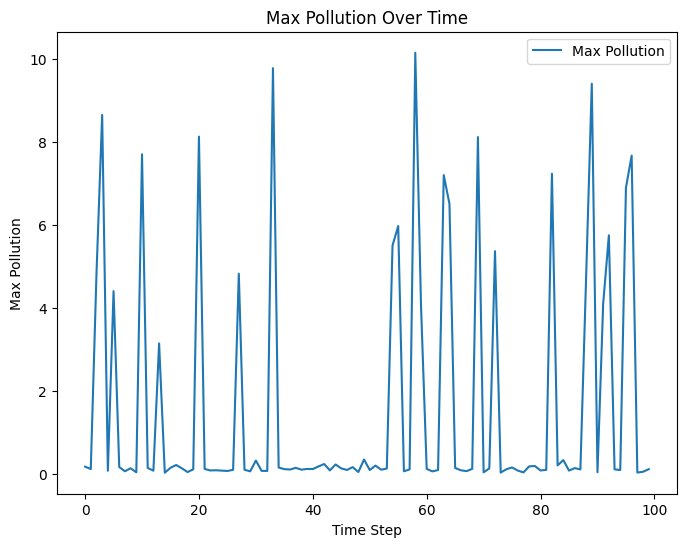

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(results[1]["max_P"], label="Max Pollution")
plt.xlabel("Time Step")
plt.ylabel("Max Pollution")
plt.title("Max Pollution Over Time")
plt.legend()
plt.show()

The pie chart represents the overall reliability

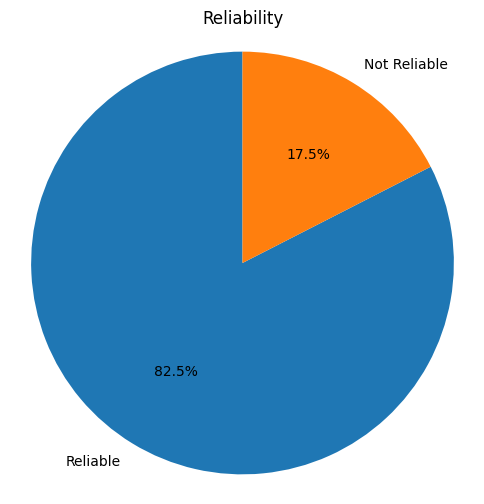

In [15]:
plt.figure(figsize=(6, 6))
labels = ["Reliable", "Not Reliable"]
sizes = [results[1]["reliability"].mean(), 1 - results[1]["reliability"].mean()]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Reliability")
plt.axis("equal")
plt.show()

# Exploratory modeling
In exploratory modeling, we are interested in understanding how regions in the uncertainty space and/or the decision space map to the whole outcome space.

There are two general approaches for investigating this mapping. 
- The first one is through systematic sampling of the uncertainty or decision space. This is sometimes also known as open exploration. 
- The second one is to search through the space in a directed manner using some type of optimization approach. This is sometimes also known as directed search.

In most applications, search is used for finding promising mappings from the decision space to the outcome space, while exploration is used to stress test these mappings under a whole range of possible resolutions to the various uncertainties.

Also  Optimization can be used to discover the worst possible scenario, while sampling can be used to get insight into the sensitivity of outcomes to the various decision levers.

## Open exploration

Let's use the Direct Policy Search (DPS) version of the lake problem (Quinn et al 2017).

We are going to simultaneously sample over uncertainties and decision levers. We are going to generate 50 scenarios and 2 policies, and see how they jointly affect the outcomes. 

* A scenario is understood as a point in the uncertainty space
* A policy is a point in the decision space. 
* The combination of a scenario and a policy is called experiment. 
* The uncertainty space is spanned by uncertainties
* The decision space is spanned by levers.

About workbench:
* Both uncertainties and levers are instances of RealParameter (a continuous range), IntegerParameter (a range of integers), or CategoricalParameter (an unorder set of things). 
* By default, the workbench will use Latin Hypercube sampling for generating both the scenarios and the policies. 
* Each policy will be always evaluated over all scenarios (i.e. a full factorial over scenarios and policies).

In [2]:
import math

# more or less default imports when using
# the workbench
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq


def get_antropogenic_release(xt, c1, c2, r1, r2, w1):
    """

    Parameters
    ----------
    xt : float
         pollution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1

    Returns
    -------
    float

    note:: w2 = 1 - w1

    """

    rule = w1 * (abs(xt - c1) / r1) ** 3 + (1 - w1) * (abs(xt - c2) / r2) ** 3
    at1 = max(rule, 0.01)
    at = min(at1, 0.1)

    return at


def lake_model(
    b=0.42,
    q=2.0,
    mean=0.02,
    stdev=0.001,
    delta=0.98,
    alpha=0.4,
    nsamples=100,
    myears=100,
    c1=0.25,
    c2=0.25,
    r1=0.5,
    r2=0.5,
    w1=0.5,
    seed=None,
):
    """runs the lake model for nsamples stochastic realisation using
    specified random seed.

    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    delta : float
            future utility discount rate
    alpha : float
            utility from pollution
    nsamples : int, optional
    myears : int, optional
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    seed : int, optional
           seed for the random number generator

    Returns
    -------
    tuple

    """
    np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q / (1 + x**q) - b * x, 0.01, 1.5)

    X = np.zeros((myears,))
    average_daily_P = np.zeros((myears,))
    reliability = 0.0
    inertia = 0
    utility = 0

    for _ in range(nsamples):
        X[0] = 0.0
        decision = 0.1

        decisions = np.zeros(myears)
        decisions[0] = decision

        natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size=myears,
        )

        for t in range(1, myears):
            # here we use the decision rule
            decision = get_antropogenic_release(X[t - 1], c1, c2, r1, r2, w1)
            decisions[t] = decision

            X[t] = (
                (1 - b) * X[t - 1]
                + X[t - 1] ** q / (1 + X[t - 1] ** q)
                + decision
                + natural_inflows[t - 1]
            )
            average_daily_P[t] += X[t] / nsamples

        reliability += np.sum(X < Pcrit) / (nsamples * myears)
        inertia += np.sum(np.absolute(np.diff(decisions) < 0.02)) / (nsamples * myears)
        utility += np.sum(alpha * decisions * np.power(delta, np.arange(myears))) / nsamples
    max_P = np.max(average_daily_P)
    return max_P, utility, inertia, reliability

In [3]:
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model

model = Model("lakeproblem", function=lake_model)

# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_P"),
    ScalarOutcome("utility"),
    ScalarOutcome("inertia"),
    ScalarOutcome("reliability"),
]

# override some of the defaults of the model
model.constants = [
    Constant("alpha", 0.41),
    Constant("nsamples", 150),
    Constant("myears", 100),
]

In [4]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

# The n_processes=-1 ensures that all cores except 1 are used, which is kept free to keep using the computer
with MultiprocessingEvaluator(model, n_processes=-1) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=2, policies=1)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 2 scenarios * 1 policies * 1 model(s) = 2 experiments
  0%|                                                    | 0/2 [00:00<?, ?it/s]